In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import bert
from bert import optimization
from bert import tokenization
from bert import modeling
import numpy as np
import json
import tensorflow as tf
import itertools
import collections
import re
import random
import sentencepiece as spm
from unidecode import unidecode
from sklearn.utils import shuffle
from tqdm import tqdm
from prepro_utils import preprocess_text, encode_ids, encode_pieces
from malaya.text.function import transformer_textcleaning as cleaning

In [3]:
sp_model = spm.SentencePieceProcessor()
sp_model.Load('sp10m.cased.bert.model')

with open('sp10m.cased.bert.vocab') as fopen:
    v = fopen.read().split('\n')[:-1]
v = [i.split('\t') for i in v]
v = {i[0]: i[1] for i in v}


class Tokenizer:
    def __init__(self, v, sp_model):
        self.vocab = v
        self.sp_model = sp_model

    def tokenize(self, string):
        return encode_pieces(
            self.sp_model, string, return_unicode = False, sample = False
        )

    def convert_tokens_to_ids(self, tokens):
        return [self.sp_model.PieceToId(piece) for piece in tokens]

    def convert_ids_to_tokens(self, ids):
        return [self.sp_model.IdToPiece(i) for i in ids]


tokenizer = Tokenizer(v, sp_model)

In [4]:
import pickle

with open('train_X.pkl', 'rb') as fopen:
    train_X, train_Y, train_depends = pickle.load(fopen)
    
with open('test_X.pkl', 'rb') as fopen:
    test_X, test_Y, test_depends = pickle.load(fopen)
    
with open('tags.pkl', 'rb') as fopen:
    idx2tag, tag2idx = pickle.load(fopen)

In [5]:
bert_config = modeling.BertConfig.from_json_file(
    'tiny-bert-v1/config.json'
)

In [6]:
BERT_INIT_CHKPNT = 'tiny-bert-v1/model.ckpt'

In [7]:
epoch = 3
batch_size = 32
warmup_proportion = 0.1
num_train_steps = int(len(train_X) / batch_size * epoch)
num_warmup_steps = int(num_train_steps * warmup_proportion)

In [8]:
class BiAAttention:
    def __init__(self, input_size_encoder, input_size_decoder, num_labels):
        self.input_size_encoder = input_size_encoder
        self.input_size_decoder = input_size_decoder
        self.num_labels = num_labels
        
        self.W_d = tf.get_variable("W_d", shape=[self.num_labels, self.input_size_decoder],
           initializer=tf.contrib.layers.xavier_initializer())
        self.W_e = tf.get_variable("W_e", shape=[self.num_labels, self.input_size_encoder],
           initializer=tf.contrib.layers.xavier_initializer())
        self.U = tf.get_variable("U", shape=[self.num_labels, self.input_size_decoder, self.input_size_encoder],
           initializer=tf.contrib.layers.xavier_initializer())
        
    def forward(self, input_d, input_e, mask_d=None, mask_e=None):
        batch = tf.shape(input_d)[0]
        length_decoder = tf.shape(input_d)[1]
        length_encoder = tf.shape(input_e)[1]
        out_d = tf.expand_dims(tf.matmul(self.W_d, tf.transpose(input_d, [0, 2, 1])), 3)
        out_e = tf.expand_dims(tf.matmul(self.W_e, tf.transpose(input_e, [0, 2, 1])), 2)
        output = tf.matmul(tf.expand_dims(input_d, 1), self.U)
        output = tf.matmul(output, tf.transpose(tf.expand_dims(input_e, 1), [0, 1, 3, 2]))
        
        output = output + out_d + out_e
        
        if mask_d is not None:
            d = tf.expand_dims(tf.expand_dims(mask_d, 1), 3)
            e = tf.expand_dims(tf.expand_dims(mask_e, 1), 2)
            output = output * d * e
            
        return output

In [9]:
class BiLinear:
    def __init__(self, left_features, right_features, out_features):
        self.left_features = left_features
        self.right_features = right_features
        self.out_features = out_features
        
        self.U = tf.get_variable("U-bi", shape=[out_features, left_features, right_features],
           initializer=tf.contrib.layers.xavier_initializer())
        self.W_l = tf.get_variable("Wl", shape=[out_features, left_features],
           initializer=tf.contrib.layers.xavier_initializer())
        self.W_r = tf.get_variable("Wr", shape=[out_features, right_features],
           initializer=tf.contrib.layers.xavier_initializer())
    
    def forward(self, input_left, input_right):
        left_size = tf.shape(input_left)
        output_shape = tf.concat([left_size[:-1], [self.out_features]], axis = 0)
        batch = tf.cast(tf.reduce_prod(left_size[:-1]), tf.int32)
        input_left = tf.reshape(input_left, (batch, self.left_features))
        input_right = tf.reshape(input_right, (batch, self.right_features))
        tiled = tf.tile(tf.expand_dims(input_left, axis = 0), (self.out_features,1,1))
        output = tf.transpose(tf.reduce_sum(tf.matmul(tiled, self.U), axis = 2))
        output = output + tf.matmul(input_left, tf.transpose(self.W_l))\
        + tf.matmul(input_right, tf.transpose(self.W_r))
        
        return tf.reshape(output, output_shape)

In [10]:
_NEG_INF = -1e9

class Model:
    def __init__(
        self,
        learning_rate,
        hidden_size_word,
        training = True,
        cov = 0.0):
        
        self.words = tf.placeholder(tf.int32, (None, None))
        self.heads = tf.placeholder(tf.int32, (None, None))
        self.types = tf.placeholder(tf.int32, (None, None))
        self.switch = tf.placeholder(tf.bool, None)
        self.mask = tf.cast(tf.math.not_equal(self.words, 0), tf.float32)
        self.maxlen = tf.shape(self.words)[1]
        self.lengths = tf.count_nonzero(self.words, 1)
        mask = self.mask
        heads = self.heads
        types = self.types
        
        self.arc_h = tf.layers.Dense(hidden_size_word)
        self.arc_c = tf.layers.Dense(hidden_size_word)
        self.attention = BiAAttention(hidden_size_word, hidden_size_word, 1)

        self.type_h = tf.layers.Dense(hidden_size_word)
        self.type_c = tf.layers.Dense(hidden_size_word)
        self.bilinear = BiLinear(hidden_size_word, hidden_size_word, len(tag2idx))
        
        model = modeling.BertModel(
            config=bert_config,
            is_training=training,
            input_ids=self.words,
            input_mask=self.mask,
            use_one_hot_embeddings=False)
        
        output_layer = model.get_sequence_output()
        
        arc_h = tf.nn.elu(self.arc_h(output_layer))
        arc_c = tf.nn.elu(self.arc_c(output_layer))
        self._arc_h = arc_h
        self._arc_c = arc_c
        
        type_h = tf.nn.elu(self.type_h(output_layer))
        type_c = tf.nn.elu(self.type_c(output_layer))
        self._type_h = type_h
        self._type_c = type_c
        
        out_arc = tf.squeeze(self.attention.forward(arc_h, arc_c, mask_d=self.mask, 
                                                    mask_e=self.mask), axis = 1)
        self.out_arc = out_arc
        
        batch = tf.shape(out_arc)[0]
        max_len = tf.shape(out_arc)[1]
        sec_max_len = tf.shape(out_arc)[2]
        batch_index = tf.range(0, batch)
        
        decode_arc = out_arc + tf.linalg.diag(tf.fill([max_len], -np.inf))
        minus_mask = tf.expand_dims(tf.cast(1 - mask, tf.bool), axis = 2)
        minus_mask = tf.tile(minus_mask, [1, 1, sec_max_len])
        decode_arc = tf.where(minus_mask, tf.fill(tf.shape(decode_arc), -np.inf), decode_arc)
        self.decode_arc = decode_arc
        self.heads_seq = tf.argmax(decode_arc, axis = 1)
        self.heads_seq = tf.identity(self.heads_seq, name = 'heads_seq')
        
#         self.decode_arc_t = tf.transpose(decode_arc, (0, 2, 1))
#         sequence_loss_depends = tf.contrib.seq2seq.sequence_loss(logits = self.decode_arc_t,
#                                                      targets = self.heads,
#                                                      weights = mask)
        
        t = tf.cast(tf.transpose(self.heads_seq), tf.int32)
        broadcasted = tf.broadcast_to(batch_index, tf.shape(t))
        concatenated = tf.transpose(tf.concat([tf.expand_dims(broadcasted, axis = 0), 
                                               tf.expand_dims(t, axis = 0)], axis = 0))
        type_h = tf.gather_nd(type_h, concatenated)
        out_type = self.bilinear.forward(type_h, type_c)
        self.tags_seq = tf.argmax(out_type, axis = 2)
        self.tags_seq = tf.identity(self.tags_seq, name = 'tags_seq')
        
        log_likelihood, transition_params = tf.contrib.crf.crf_log_likelihood(
            out_type, self.types, self.lengths
        )
        crf_loss = tf.reduce_mean(-log_likelihood)
        self.logits, _ = tf.contrib.crf.crf_decode(
            out_type, transition_params, self.lengths
        )
        self.logits = tf.identity(self.logits, name = 'logits')
        
        batch = tf.shape(out_arc)[0]
        max_len = tf.shape(out_arc)[1]
        batch_index = tf.range(0, batch)
        t = tf.transpose(heads)
        broadcasted = tf.broadcast_to(batch_index, tf.shape(t))
        concatenated = tf.transpose(tf.concat([tf.expand_dims(broadcasted, axis = 0), 
                                               tf.expand_dims(t, axis = 0)], axis = 0))
        type_h = tf.gather_nd(type_h, concatenated)
        out_type = self.bilinear.forward(type_h, type_c)
        minus_inf = -1e8
        minus_mask = (1 - mask) * minus_inf
        out_arc = out_arc + tf.expand_dims(minus_mask, axis = 2) + tf.expand_dims(minus_mask, axis = 1)
        loss_arc = tf.nn.log_softmax(out_arc, dim=1)
        loss_type = tf.nn.log_softmax(out_type, dim=2)
        loss_arc = loss_arc * tf.expand_dims(mask, axis = 2) * tf.expand_dims(mask, axis = 1)
        loss_type = loss_type * tf.expand_dims(mask, axis = 2)
        num = tf.reduce_sum(mask) - tf.cast(batch, tf.float32)
        child_index = tf.tile(tf.expand_dims(tf.range(0, max_len), 1), [1, batch])
        t = tf.transpose(heads)
        broadcasted = tf.broadcast_to(batch_index, tf.shape(t))
        concatenated = tf.transpose(tf.concat([tf.expand_dims(broadcasted, axis = 0),
                                               tf.expand_dims(t, axis = 0),
                                               tf.expand_dims(child_index, axis = 0)], axis = 0))
        loss_arc = tf.gather_nd(loss_arc, concatenated)
        loss_arc = tf.transpose(loss_arc, [1, 0])
        
        t = tf.transpose(types)
        broadcasted = tf.broadcast_to(batch_index, tf.shape(t))
        concatenated = tf.transpose(tf.concat([tf.expand_dims(broadcasted, axis = 0),
                                               tf.expand_dims(child_index, axis = 0),
                                               tf.expand_dims(t, axis = 0)], axis = 0))
        loss_type = tf.gather_nd(loss_type, concatenated)
        loss_type = tf.transpose(loss_type, [1, 0])
        cost = (tf.reduce_sum(-loss_arc) / num) + (tf.reduce_sum(-loss_type) / num)
        
        self.cost = tf.cond(self.switch, lambda: cost + crf_loss, lambda: cost)
        self.optimizer = optimization.create_optimizer(self.cost, learning_rate, 
                                                       num_train_steps, num_warmup_steps, False)
        
        mask = tf.sequence_mask(self.lengths, maxlen = self.maxlen)
        
        self.prediction = tf.boolean_mask(self.logits, mask)
        mask_label = tf.boolean_mask(self.types, mask)
        correct_pred = tf.equal(tf.cast(self.prediction, tf.int32), mask_label)
        correct_index = tf.cast(correct_pred, tf.float32)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        self.prediction = tf.cast(tf.boolean_mask(self.heads_seq, mask), tf.int32)
        mask_label = tf.boolean_mask(self.heads, mask)
        correct_pred = tf.equal(self.prediction, mask_label)
        correct_index = tf.cast(correct_pred, tf.float32)
        self.accuracy_depends = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [11]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

learning_rate = 2e-5
hidden_size_word = 256

model = Model(learning_rate, hidden_size_word)
sess.run(tf.global_variables_initializer())

Instructions for updating:
reduction_indices is deprecated, use axis instead
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
dim is deprecated, use axis instead





In [12]:
var_lists = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'bert')
saver = tf.train.Saver(var_list = var_lists)
saver.restore(sess, BERT_INIT_CHKPNT)

INFO:tensorflow:Restoring parameters from tiny-bert-v1/model.ckpt


In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

batch_x = train_X[:5]
batch_x = pad_sequences(batch_x,padding='post')
batch_y = train_Y[:5]
batch_y = pad_sequences(batch_y,padding='post')
batch_depends = train_depends[:5]
batch_depends = pad_sequences(batch_depends,padding='post')

In [14]:
sess.run([model.accuracy, model.accuracy_depends, model.cost],
        feed_dict = {model.words: batch_x,
                model.types: batch_y,
                model.heads: batch_depends,
                model.switch: False})

[0.01369863, 0.09589041, 30.746227]

In [15]:
sess.run([model.accuracy, model.accuracy_depends, model.cost],
        feed_dict = {model.words: batch_x,
                model.types: batch_y,
                model.heads: batch_depends,
                model.switch: True})

[0.01369863, 0.09589041, 157.3611]

In [16]:
from tqdm import tqdm

epoch = 2

for e in range(epoch):
    train_acc, train_loss = [], []
    test_acc, test_loss = [], []
    train_acc_depends, test_acc_depends = [], []
    
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        index = min(i + batch_size, len(train_X))
        batch_x = train_X[i: index]
        batch_x = pad_sequences(batch_x,padding='post')
        batch_y = train_Y[i: index]
        batch_y = pad_sequences(batch_y,padding='post')
        batch_depends = train_depends[i: index]
        batch_depends = pad_sequences(batch_depends,padding='post')
        
        if batch_x.shape == batch_y.shape:
            acc_depends, acc, cost, _ = sess.run(
                [model.accuracy_depends, model.accuracy, model.cost, model.optimizer],
                feed_dict = {
                    model.words: batch_x,
                    model.types: batch_y,
                    model.heads: batch_depends,
                    model.switch: False
                },
            )
            train_loss.append(cost)
            train_acc.append(acc)
            train_acc_depends.append(acc_depends)
            pbar.set_postfix(cost = cost, accuracy = acc, accuracy_depends = acc_depends)
        
    pbar = tqdm(
        range(0, len(test_X), batch_size), desc = 'test minibatch loop'
    )
    for i in pbar:
        index = min(i + batch_size, len(test_X))
        batch_x = test_X[i: index]
        batch_x = pad_sequences(batch_x,padding='post')
        batch_y = test_Y[i: index]
        batch_y = pad_sequences(batch_y,padding='post')
        batch_depends = test_depends[i: index]
        batch_depends = pad_sequences(batch_depends,padding='post')
        
        if batch_x.shape == batch_y.shape:
            acc_depends, acc, cost = sess.run(
                [model.accuracy_depends, model.accuracy, model.cost],
                feed_dict = {
                    model.words: batch_x,
                    model.types: batch_y,
                    model.heads: batch_depends,
                    model.switch: False
                },
            )
            test_loss.append(cost)
            test_acc.append(acc)
            test_acc_depends.append(acc_depends)
            pbar.set_postfix(cost = cost, accuracy = acc, accuracy_depends = acc_depends)
    
    
    print(
    'epoch: %d, training loss: %f, training acc: %f, training depends: %f, valid loss: %f, valid acc: %f, valid depends: %f\n'
    % (e, np.mean(train_loss), 
       np.mean(train_acc), 
       np.mean(train_acc_depends), 
       np.mean(test_loss), 
       np.mean(test_acc), 
       np.mean(test_acc_depends)
    ))
    
    saver = tf.train.Saver(tf.trainable_variables())
    saver.save(sess, 'tiny-bert-dependency/model.ckpt')

train minibatch loop:   8%|▊         | 8228/97788 [21:47<3:47:18,  6.57it/s, accuracy=0.815, accuracy_depends=0.494, cost=1.85] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

test minibatch loop: 100%|██████████| 313/313 [00:36<00:00,  8.65it/s, accuracy=0.89, accuracy_depends=0.741, cost=0.799] 


epoch: 0, training loss: 1.250804, training acc: 0.847605, training depends: 0.668640, valid loss: 0.735416, valid acc: 0.884954, valid depends: 0.744215



test minibatch loop: 100%|██████████| 313/313 [00:35<00:00,  8.70it/s, accuracy=0.89, accuracy_depends=0.743, cost=0.689] 


epoch: 1, training loss: 0.664987, training acc: 0.888118, training depends: 0.757840, valid loss: 0.641807, valid acc: 0.889845, valid depends: 0.765465



In [17]:
from tqdm import tqdm

epoch = 1

for e in range(epoch):
    train_acc, train_loss = [], []
    test_acc, test_loss = [], []
    train_acc_depends, test_acc_depends = [], []
    
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        index = min(i + batch_size, len(train_X))
        batch_x = train_X[i: index]
        batch_x = pad_sequences(batch_x,padding='post')
        batch_y = train_Y[i: index]
        batch_y = pad_sequences(batch_y,padding='post')
        batch_depends = train_depends[i: index]
        batch_depends = pad_sequences(batch_depends,padding='post')
        
        if batch_x.shape == batch_y.shape:
            acc_depends, acc, cost, _ = sess.run(
                [model.accuracy_depends, model.accuracy, model.cost, model.optimizer],
                feed_dict = {
                    model.words: batch_x,
                    model.types: batch_y,
                    model.heads: batch_depends,
                    model.switch: True
                },
            )
            train_loss.append(cost)
            train_acc.append(acc)
            train_acc_depends.append(acc_depends)
            pbar.set_postfix(cost = cost, accuracy = acc, accuracy_depends = acc_depends)
        
    pbar = tqdm(
        range(0, len(test_X), batch_size), desc = 'test minibatch loop'
    )
    for i in pbar:
        index = min(i + batch_size, len(test_X))
        batch_x = test_X[i: index]
        batch_x = pad_sequences(batch_x,padding='post')
        batch_y = test_Y[i: index]
        batch_y = pad_sequences(batch_y,padding='post')
        batch_depends = test_depends[i: index]
        batch_depends = pad_sequences(batch_depends,padding='post')
        
        if batch_x.shape == batch_y.shape:
            acc_depends, acc, cost = sess.run(
                [model.accuracy_depends, model.accuracy, model.cost],
                feed_dict = {
                    model.words: batch_x,
                    model.types: batch_y,
                    model.heads: batch_depends,
                    model.switch: True
                },
            )
            test_loss.append(cost)
            test_acc.append(acc)
            test_acc_depends.append(acc_depends)
            pbar.set_postfix(cost = cost, accuracy = acc, accuracy_depends = acc_depends)
    
    
    print(
    'epoch: %d, training loss: %f, training acc: %f, training depends: %f, valid loss: %f, valid acc: %f, valid depends: %f\n'
    % (e, np.mean(train_loss), 
       np.mean(train_acc), 
       np.mean(train_acc_depends), 
       np.mean(test_loss), 
       np.mean(test_acc), 
       np.mean(test_acc_depends)
    ))
    
    saver = tf.train.Saver(tf.trainable_variables())
    saver.save(sess, 'tiny-bert-dependency/model.ckpt')

test minibatch loop: 100%|██████████| 313/313 [00:36<00:00,  8.61it/s, accuracy=0.9, accuracy_depends=0.778, cost=0.629]  


epoch: 0, training loss: 0.602583, training acc: 0.890296, training depends: 0.772322, valid loss: 0.611718, valid acc: 0.891331, valid depends: 0.773028



test minibatch loop: 100%|██████████| 313/313 [00:34<00:00,  9.09it/s, accuracy=0.885, accuracy_depends=0.788, cost=0.621]


epoch: 1, training loss: 0.587275, training acc: 0.891074, training depends: 0.775791, valid loss: 0.609368, valid acc: 0.890627, valid depends: 0.773412



In [18]:
def merge_sentencepiece_tokens_tagging(x, y):
    new_paired_tokens = []
    n_tokens = len(x)
    rejected = ['[CLS]', '[SEP]']

    i = 0

    while i < n_tokens:

        current_token, current_label = x[i], y[i]
        if not current_token.startswith('▁') and current_token not in rejected:
            previous_token, previous_label = new_paired_tokens.pop()
            merged_token = previous_token
            merged_label = [previous_label]
            while (
                not current_token.startswith('▁')
                and current_token not in rejected
            ):
                merged_token = merged_token + current_token.replace('▁', '')
                merged_label.append(current_label)
                i = i + 1
                current_token, current_label = x[i], y[i]
            merged_label = merged_label[0]
            new_paired_tokens.append((merged_token, merged_label))

        else:
            new_paired_tokens.append((current_token, current_label))
            i = i + 1

    words = [
        i[0].replace('▁', '')
        for i in new_paired_tokens
        if i[0] not in rejected
    ]
    labels = [i[1] for i in new_paired_tokens if i[0] not in rejected]
    return words, labels

In [19]:
import re
from unidecode import unidecode
from malaya.function.parse_dependency import DependencyGraph

PUNCTUATION = '!"#$%&\'()*+,./:;<=>?@[\]^_`{|}~'

def transformer_textcleaning(string):
    """
    use by any transformer model before tokenization
    """
    string = unidecode(string)
    string = re.sub('\\(dot\\)', '.', string)
    string = (
        re.sub(re.findall(r'\<a(.*?)\>', string)[0], '', string)
        if (len(re.findall(r'\<a (.*?)\>', string)) > 0)
        and ('href' in re.findall(r'\<a (.*?)\>', string)[0])
        else string
    )
    string = re.sub(
        r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', string
    )
    string = re.sub(r'[ ]+', ' ', string).strip().split()
    string = [w for w in string if w[0] != '@']
    string = ' '.join(string)
    string = re.sub(f'([{PUNCTUATION}])', r' \1 ', string)
    string = re.sub('\s{2,}', ' ', string)
    original_string = string.split()
    string = [
        (original_string[no], word.title() if word.isupper() else word)
        for no, word in enumerate(string.split())
        if len(word)
    ]
    return [s[0] for s in string], [s[1] for s in string]

def parse_X(left):
    bert_tokens = ['[CLS]']
    for no, orig_token in enumerate(left):
        t = tokenizer.tokenize(orig_token)
        bert_tokens.extend(t)
    bert_tokens.append("[SEP]")
    t = tokenizer.convert_tokens_to_ids(bert_tokens)
    return t, bert_tokens, [1] * len(t)

In [20]:
def dependency_graph(tagging, indexing):
    """
    Return helper object for dependency parser results. Only accept tagging and indexing outputs from dependency models.
    """
    result = []
    for i in range(len(tagging)):
        result.append(
            '%d\t%s\t_\t_\t_\t_\t%d\t%s\t_\t_'
            % (i + 1, tagging[i][0], int(indexing[i][1]), tagging[i][1])
        )
    return DependencyGraph('\n'.join(result), top_relation_label='root')

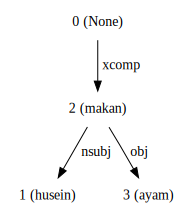

In [21]:
string = 'husein makan ayam'
sequence = transformer_textcleaning(string)[1]
parsed_sequence, bert_sequence, mask = parse_X(sequence)
h, t = sess.run([model.heads_seq, model.tags_seq],
        feed_dict = {
            model.words: [parsed_sequence],
        },
)
h = h[0] - 2
t = [idx2tag[d] for d in t[0]]
merged_h = merge_sentencepiece_tokens_tagging(bert_sequence, h)
merged_t = merge_sentencepiece_tokens_tagging(bert_sequence, t)
tagging = list(zip(merged_t[0], merged_t[1]))
indexing = list(zip(merged_h[0], merged_h[1]))
dep = dependency_graph(tagging, indexing)
dep.to_graphvis()

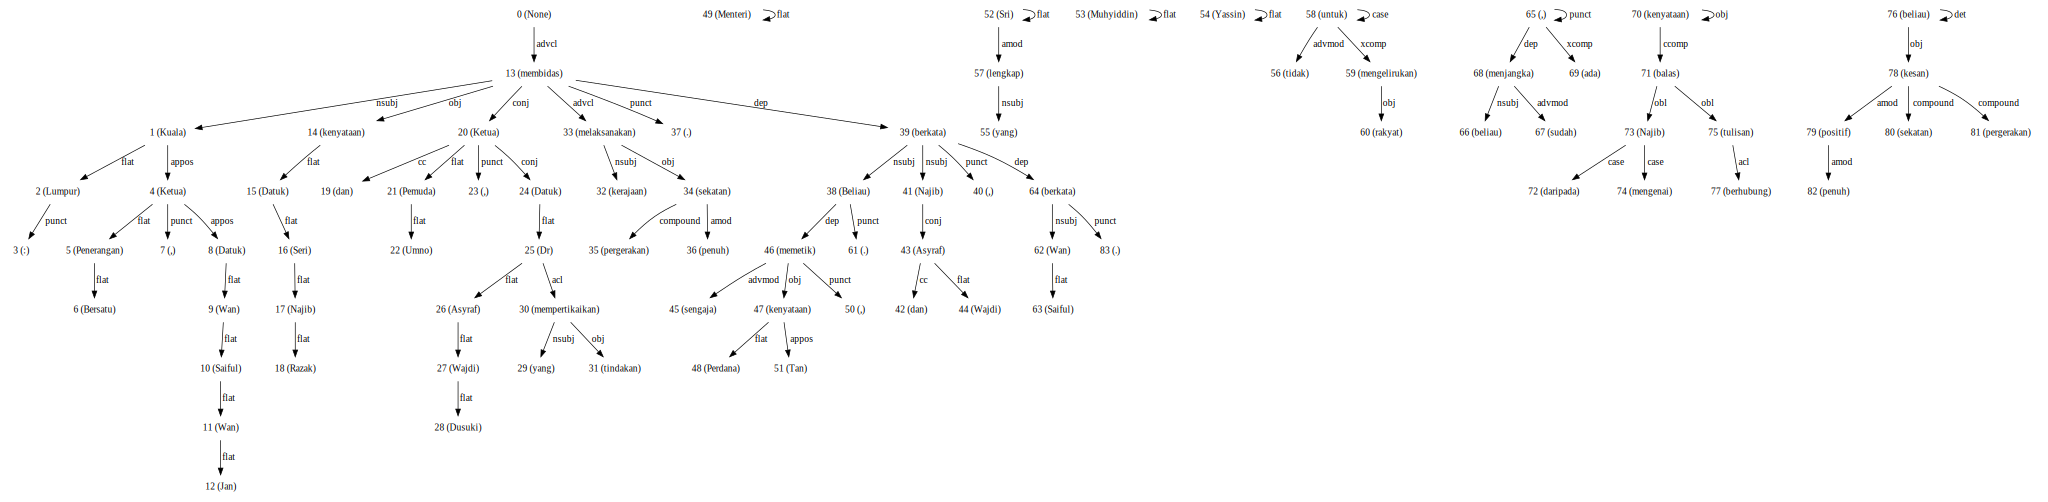

In [22]:
string = 'KUALA LUMPUR: Ketua Penerangan BERSATU, Datuk Wan Saiful Wan Jan membidas kenyataan Datuk Seri Najib Razak dan Ketua Pemuda UMNO, Datuk Dr Asyraf Wajdi Dusuki yang mempertikaikan tindakan kerajaan melaksanakan sekatan pergerakan penuh. Beliau berkata, Najib dan Asyraf Wajdi sengaja memetik kenyataan Perdana Menteri, Tan Sri Muhyiddin Yassin yang tidak lengkap untuk mengelirukan rakyat. Wan Saiful berkata, beliau sudah menjangka ada kenyataan balas daripada Najib mengenai tulisan beliau berhubung kesan positif sekatan pergerakan penuh.'
sequence = transformer_textcleaning(string)[1]
parsed_sequence, bert_sequence, mask = parse_X(sequence)
h, t = sess.run([model.heads_seq, model.tags_seq],
        feed_dict = {
            model.words: [parsed_sequence],
        },
)
h = h[0] - 2
t = [idx2tag[d] for d in t[0]]
merged_h = merge_sentencepiece_tokens_tagging(bert_sequence, h)
merged_t = merge_sentencepiece_tokens_tagging(bert_sequence, t)
tagging = list(zip(merged_t[0], merged_t[1]))
indexing = list(zip(merged_h[0], merged_h[1]))
dep = dependency_graph(tagging, indexing)
dep.to_graphvis()

In [23]:
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'tiny-bert-dependency/model.ckpt')

'tiny-bert-dependency/model.ckpt'

In [24]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

learning_rate = 2e-5
hidden_size_word = 256

model = Model(learning_rate, hidden_size_word, training = False)

sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.trainable_variables())
saver.restore(sess, 'tiny-bert-dependency/model.ckpt')

INFO:tensorflow:Restoring parameters from tiny-bert-dependency/model.ckpt


In [25]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p])
        out.append(out_i)
    return out

In [26]:
def evaluate(heads_pred, types_pred, heads, types, lengths,
             symbolic_root=False, symbolic_end=False):
    batch_size, _ = heads_pred.shape
    ucorr = 0.
    lcorr = 0.
    total = 0.
    ucomplete_match = 0.
    lcomplete_match = 0.

    corr_root = 0.
    total_root = 0.
    start = 1 if symbolic_root else 0
    end = 1 if symbolic_end else 0
    for i in range(batch_size):
        ucm = 1.
        lcm = 1.
        for j in range(start, lengths[i] - end):

            total += 1
            if heads[i, j] == heads_pred[i, j]:
                ucorr += 1
                if types[i, j] == types_pred[i, j]:
                    lcorr += 1
                else:
                    lcm = 0
            else:
                ucm = 0
                lcm = 0

            if heads[i, j] == 0:
                total_root += 1
                corr_root += 1 if heads_pred[i, j] == 0 else 0

        ucomplete_match += ucm
        lcomplete_match += lcm
    
    return ucorr / total, lcorr / total, corr_root / total_root

In [27]:
arcs, types, roots = [], [], []
real_Y, predict_Y = [], []

for i in tqdm(range(0, len(test_X), batch_size)):
    index = min(i + batch_size, len(test_X))
    batch_x = test_X[i: index]
    batch_x = pad_sequences(batch_x,padding='post')
    batch_y = test_Y[i: index]
    batch_y = pad_sequences(batch_y,padding='post')
    batch_depends = test_depends[i: index]
    batch_depends = pad_sequences(batch_depends,padding='post')
    
    tags_seq, heads = sess.run(
        [model.logits, model.heads_seq],
        feed_dict = {
            model.words: batch_x,
        },
    )
    
    arc_accuracy, type_accuracy, root_accuracy = evaluate(heads - 1, tags_seq, batch_depends - 1, batch_y, 
            np.count_nonzero(batch_x, axis = 1))
    arcs.append(arc_accuracy)
    types.append(type_accuracy)
    roots.append(root_accuracy)
    predicted = pred2label(tags_seq)
    real = pred2label(batch_y)
    predict_Y.extend(predicted)
    real_Y.extend(real)

100%|██████████| 313/313 [00:38<00:00,  8.12it/s]


In [28]:
temp_real_Y = []
for r in real_Y:
    temp_real_Y.extend(r)
    
temp_predict_Y = []
for r in predict_Y:
    temp_predict_Y.extend(r)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(temp_real_Y, temp_predict_Y, digits = 5))

               precision    recall  f1-score   support

          PAD    0.99958   1.00000   0.99979    656062
            X    0.99998   0.99232   0.99613     61945
          acl    0.64541   0.81625   0.72085      3298
        advcl    0.27776   0.56039   0.37142      1656
       advmod    0.91310   0.92373   0.91839      6700
         amod    0.82278   0.86302   0.84242      4621
        appos    0.76714   0.69299   0.72818      3052
         case    0.96439   0.97337   0.96886     11492
           cc    0.98187   0.96747   0.97461      3750
        ccomp    0.45118   0.34987   0.39412       383
     compound    0.83453   0.89652   0.86442     11133
compound:plur    0.43478   0.33333   0.37736        30
         conj    0.84660   0.85878   0.85265      5424
          cop    0.97119   0.95659   0.96384       599
        csubj    0.25000   0.10000   0.14286        10
   csubj:pass    0.00000   0.00000   0.00000         1
          dep    0.45412   0.53168   0.48985       363
         

In [30]:
print('arc accuracy:', np.mean(arcs))
print('types accuracy:', np.mean(types))
print('root accuracy:', np.mean(roots))

arc accuracy: 0.795252499643322
types accuracy: 0.7247015428088897
root accuracy: 0.9893913291696776


In [31]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or '_seq' in n.name
        or 'alphas' in n.name
        or 'logits' in n.name
        or 'self/Softmax' in n.name)
        and 'Adam' not in n.name
        and 'beta' not in n.name
        and 'global_step' not in n.name
        and 'adam' not in n.name
        and 'gradients/bert' not in n.name
    ]
)

In [32]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [33]:
freeze_graph('tiny-bert-dependency', strings)

INFO:tensorflow:Restoring parameters from tiny-bert-dependency/model.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 86 variables.
INFO:tensorflow:Converted 86 variables to const ops.
1400 ops in the final graph.


In [34]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics, op=Dropout)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-10, fallback_max=10)',
             'strip_unused_nodes',
             'sort_by_execution_order']

In [35]:
from tensorflow.tools.graph_transforms import TransformGraph
tf.set_random_seed(0)

pb = 'tiny-bert-dependency/frozen_model.pb'
input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

if 'bert' in pb:
    inputs = ['Placeholder']
    a = ['dense/BiasAdd']
if 'xlnet' in pb:
    inputs = ['Placeholder', 'Placeholder_1', 'Placeholder_2']
    a = ['transpose_3']

transformed_graph_def = TransformGraph(input_graph_def, 
                                       inputs,
                                       ['logits', 'heads_seq'] + a, transforms)

with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

Instructions for updating:
Use tf.gfile.GFile.
